# Set Up
Uncomment the code below to get the necessary libraries

In [28]:
! pip install numpy pandas altair seaborn scikit-learn xgboost gradio plotly matplotlib nbformat

# **1 - Reading Data**

In [29]:
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns    
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px    
from pandas import DataFrame    
import gradio as gr 
import xgboost as xgb

In [30]:
train1 = pd.read_csv("../data/train1.csv")
train2 = pd.read_csv("../data/train2.csv")
train = pd.concat([train1,train2])

test = pd.read_csv("../data/test.csv")

# **2 - EDA**

**1.1 - Basic Data Understanding**

We'll take a peak of the data set to aquire basic understanding of it

In [31]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


**2.2 -  Cleaning The Data**

Now, well check for null values

In [32]:
train.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [33]:
test.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64

There are 201 missing values in the BMI column in the train data set.
That can be handled in various ways. Here, we will fill the missing data in the BMI column with the average of the same column.

In [34]:
bmi_mean = train.bmi.mean()
train['bmi'] = train.bmi.fillna(bmi_mean)
train.bmi.isnull().sum()

0

**2.3 - Data Visuilization**

First, we'll use a heatmap to see the correlation between the numerical variables 

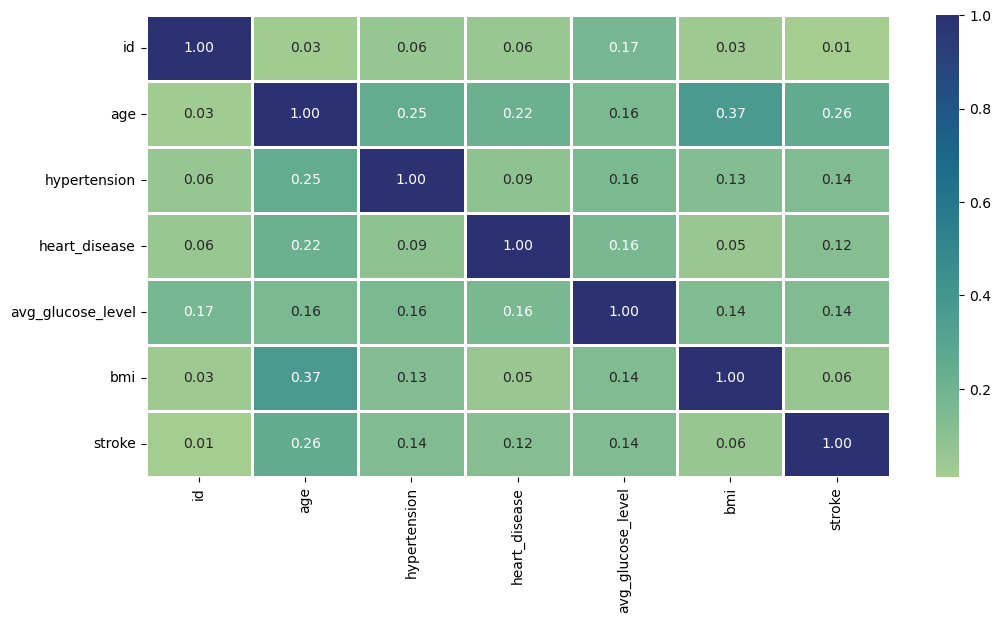

In [35]:
plt.figure(figsize=(12, 6))
sns.heatmap(train.corr(numeric_only=True),
            cmap = 'crest',
            fmt = '.2f', #to covert to float
            linewidths = 2,
            annot = True); #to show values

From the previous visuilization, we can have a general understanding of the relationship between the numerical variables. However we want to further investigate in details the relationship between each variable and the stroke variable. 

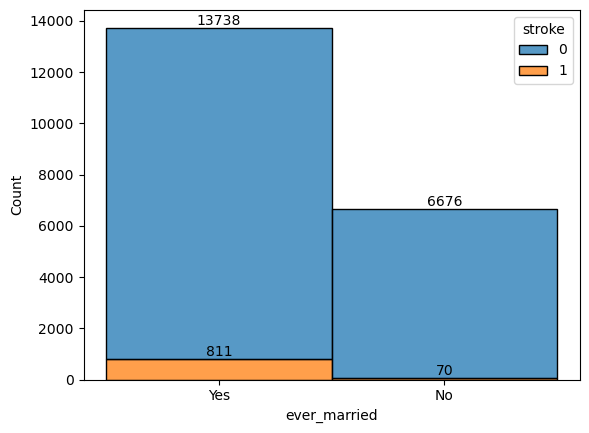

In [36]:
hs = sns.histplot(data=train, x="ever_married", hue = "stroke", multiple="stack")
hs.bar_label(hs.containers[0]); #to show number of stroke data
hs.bar_label(hs.containers[1]); #to show number of marriage data
plt.show()

The data show higher stroke rates among people who have ever been married.
About 6.27% who have ever been married had a stroke, and about 1.06% among people who have not.

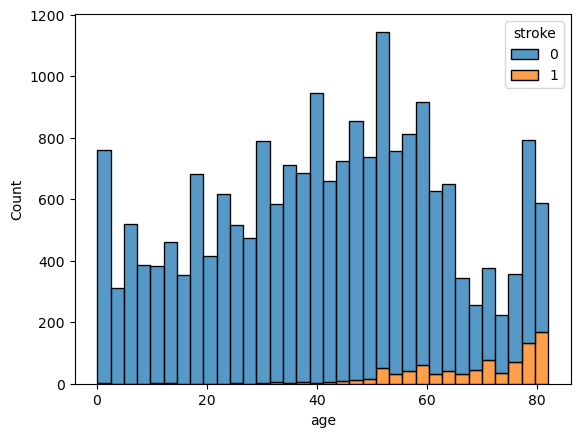

In [37]:
hs = sns.histplot(data=train, x="age", hue = "stroke", multiple="stack")
plt.show()

There's an obvious trend here; elder people are more septeable to having strokes.

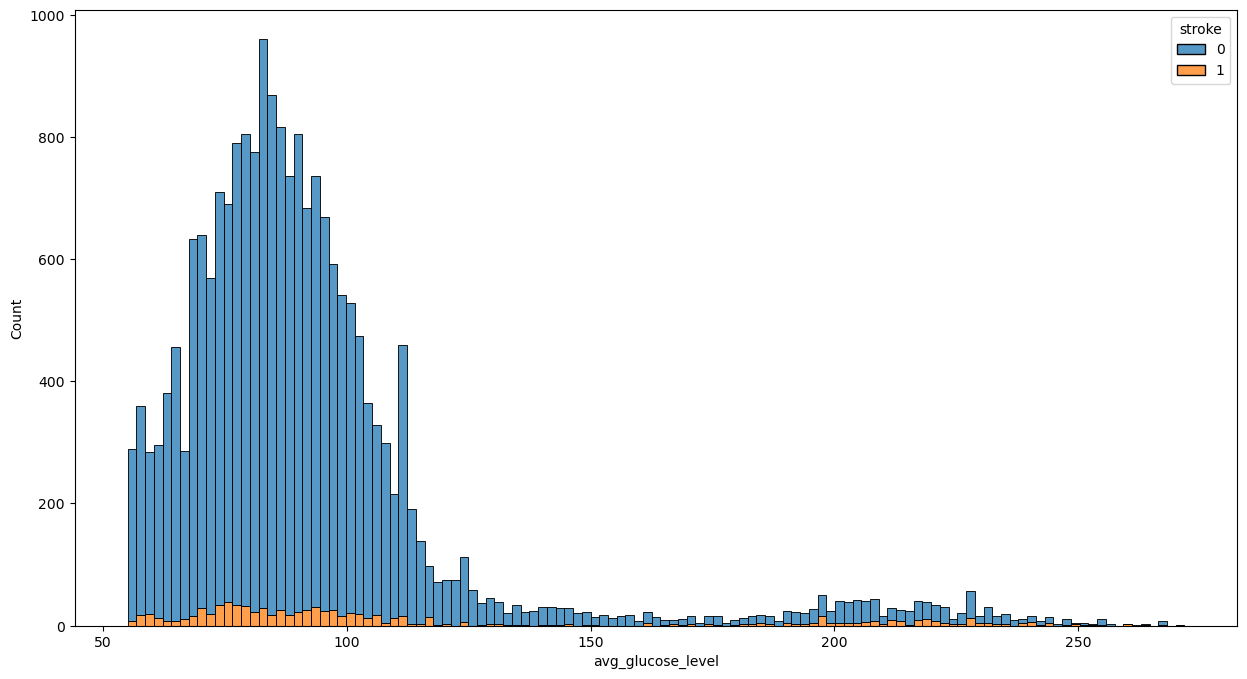

In [38]:
plt.figure(figsize = (15, 8))
sns.histplot(data=train, x="avg_glucose_level", hue="stroke", multiple="stack")
plt.show()

There is not a strong corellation between the average glucose level and having a stroke.

[Text(0, 0, '450'), Text(0, 0, '431')]

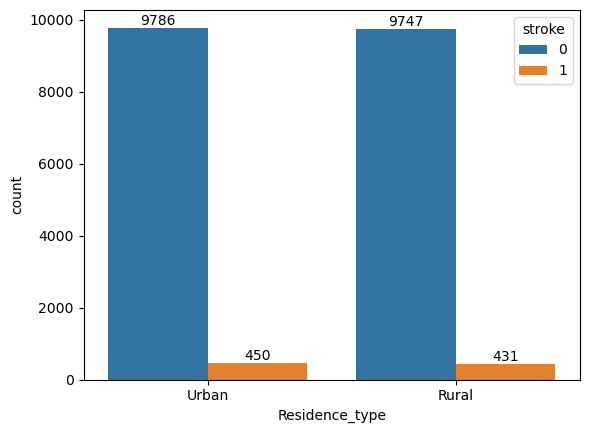

In [39]:
ax = sns.countplot(data=train, x="Residence_type",hue = "stroke")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])


The stroke proportion difference between urban redsidents and rural residents is negligible, thus suggesting that there is no correlation.

[Text(0, 0, '768'), Text(0, 0, '113')]

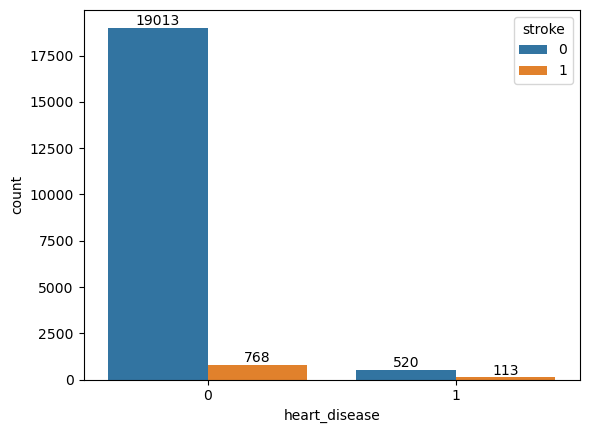

In [40]:
ax = sns.countplot(data=train, x="heart_disease",hue = "stroke")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])


Only 4.04% of people with heart diseases have had a stroke, and 21.73% of people who have heart diseases have had a stroke. Therefore, there is strong correlation between the two.

[Text(0, 0, '687'), Text(0, 0, '194')]

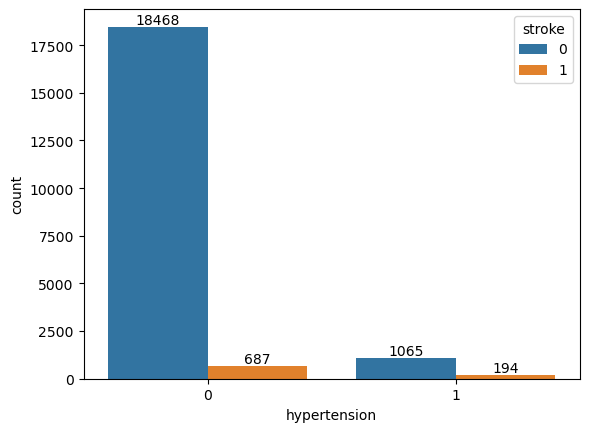

In [41]:
ax = sns.countplot(data=train, x="hypertension",hue = "stroke")
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

There's greater stroke proportion among people with hypertension that those who don't have hypertension, thus showing strong correlation.

In [42]:
fig=px.histogram(train, x="bmi", color="stroke", barmode='group', text_auto=True)
fig.update_layout(yaxis_title="count")
fig.update_layout(
                  legend_title_font_color="magenta",
                  yaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  xaxis=dict(tickfont=dict(size=15), titlefont=dict(size=20)),
                  legend_font_size=12)
newnames = {'0': 'No', '1': 'Yes'}
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(
                                          t.name, newnames[t.name])))
fig.show()


There does not seem to be a noticable trend; the stroke data, as the bmi data, is normally distibuted. The acute peak at the mean could be explained by the fact that we replaced the missing values with the mean.

In [43]:
threeD = pd.concat([train1, train2])


stroke_mapping = {1: 'yes', 0: 'no'}
threeD["stroke"] = threeD["stroke"].map(stroke_mapping)

fig = px.scatter_3d(threeD, x='avg_glucose_level', y='age', z='bmi', color='stroke')
fig.update_traces(marker=dict(size=3)) 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


# **3 - Feature Engineering**

Here, we will be converting the catagorical values into numerical ones.

In [44]:
#for the train data set
train = train.drop(columns=['id'])
train['gender'] = train['gender'].apply(lambda x: 0 if x == 'Male' else 1)
train['ever_married'] = train['ever_married'].apply(lambda x: 0 if x == 'yes' else 1)
train['Residence_type'] = train['Residence_type'].apply(lambda x: 0 if x == 'Urban' else 1)
train['work_type'].replace(train['work_type'].unique(),
                        [0, 1, 2, 3, 4], inplace=True)
train['smoking_status'].replace(train['smoking_status'].unique(),
                        [0, 1, 2, 3], inplace=True)

In [45]:
#for the test data set
test = test.drop(columns=['id'])
test['gender'] = test['gender'].apply(lambda x: 0 if x == 'Male' else 1)
test['ever_married'] = test['ever_married'].apply(lambda x: 0 if x == 'yes' else 1)
test['Residence_type'] = test['Residence_type'].apply(lambda x: 0 if x == 'Urban' else 1)
test['work_type'].replace(test['work_type'].unique(),
                        [0, 1, 2, 3, 4], inplace=True)
test['smoking_status'].replace(test['smoking_status'].unique(),
                        [0, 1, 2, 3], inplace=True)

# **4 - Model**

In [46]:
#spliting data
X = train.loc[:,train.columns != 'stroke']
y = train['stroke']
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
#model building
model = xgb.XGBClassifier(
    seed=42,
    learning_rate=0.15,  # Adjust the learning rate 
    n_estimators=100,  # Increase the number of estimators
    max_depth=5,  # Adjust the maximum depth of each tree
    subsample=0.8,  # Adjust the subsample ratio
    colsample_bytree=0.8,  # Adjust the column subsample ratio
    alpha = 0.4, #Adjust the complexity of a tree
    gamma = 0.4, #Adjust the complexity of a tree
    min_child_weight = 5 #sets the weight limit for a tree node to split
)

In [48]:
# Fit the model with data
model.fit(
    train_set_x, train_set_y,
    eval_set=[(train_set_x, train_set_y), (test_set_x, test_set_y)],
    verbose=False,
    early_stopping_rounds=10 
)

/opt/anaconda3/envs/datasciecne/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



XGBClassifier(alpha=0.4, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [49]:
best_n_rounds = model.best_iteration

y_pred = model.predict(test_set_x, ntree_limit=best_n_rounds)

/opt/anaconda3/envs/datasciecne/lib/python3.11/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



# **5 - Submission**

In [50]:
import pickle
# Save the model to a file using pickle
with open("model.pkl", "wb") as file:
    pickle.dump(model, file)

In [51]:
# Load the model from the file using pickle
with open("model.pkl", "rb") as file:
    model = pickle.load(file)

In [52]:
test_sub = pd.read_csv('/Users/macbookair/Desktop/Projects/GitHub/Stroke-prediction/data/test.csv')
test_sub['stroke'] = model.predict_proba(test)[:,1]

In [53]:
import os
# Create the 'data' directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')



## Gradio Deployment ##

In [54]:
def predict_stroke(gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status):
    data = pd.DataFrame({
        'gender': [0 if gender == 'Male' else 1],
        'age': [age],
        'hypertension': [hypertension],
        'heart_disease': [heart_disease],
        'ever_married': [0 if ever_married == 'Yes' else 1],
        'avg_glucose_level': [avg_glucose_level],
        'bmi': [bmi],
        'work_type': [work_type],
        'Residence_type': [Residence_type],
        'smoking_status': [smoking_status]
    })

    # One-hot encode categorical variables
    data = pd.get_dummies(data, columns=['work_type', 'Residence_type', 'smoking_status'])

    # Ensure only necessary columns are included
    data = data.reindex(columns=model.get_booster().feature_names, fill_value=0)

    prediction = model.predict_proba(data)[:, 1]
    probability = prediction[0] * 100
    return f"{probability:.2f}%"


inputs = [
    gr.components.Dropdown(['Male', 'Female'], label="Gender"),
    gr.components.Number(label="Age"),
    gr.components.Checkbox(label="Hypertension"),
    gr.components.Checkbox(label="Heart Disease"),
    gr.components.Dropdown(['Yes', 'No'], label="Ever Married"),
    gr.components.Dropdown(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'], label="Work Type"),
    gr.components.Dropdown(['Urban', 'Rural'], label="Residence Type"),
    gr.components.Number(label="Average Glucose Level"),
    gr.components.Number(label="BMI"),
    gr.components.Dropdown(['Unknown', 'Never smoked', 'Formerly smoked', 'Smokes'], label="Smoking Status")
]


output = gr.components.Label(label="Stroke Probability")
interface = gr.Interface(fn=predict_stroke, inputs=inputs, outputs=output, title="Stroke Prediction",
                         description= '''This is a machine learning model that predicts stroke probability of an individual given parameters regarding their gender, age, lifestyle, and health.
                         Full documentation of the model could be found through the following Github repository: https://github.com/kokomug/stroke-prodiction.git''')



interface.launch(share = True)


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://01b1fe2a47b1edd2e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
